### 2024/01/31 異常検知のための機械学習手法の調査

##### ▶指針
・コサイン類似度の時系列データを入力したい<br>
・ストロークどうしのコサイン類似度を比べるよりかは、ストローク内のコサイン類似度の関係性を保持したい<br>

##### ▶手法の候補
・外れ値検知<br>
・DTW(座標数が異なっていても対応可)<br>
・K-shape<br>
・Auto Encoder<br>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import umap
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from view_function import ViewFunction
vf = ViewFunction()
from preprocessed_data_plusinfo import PreprocessedDataPlusInfo

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [3]:
box_abct_nopt = pd.read_pickle('../temp/20240117_box_abct_nopt_rmoverlapcoord.pkl')

In [3]:
# 座標数の調査
# cnt_coord = [ len(coords) for coords in box_abct_nopt['ptx_mm']]
# plt.boxplot(cnt_coord, whis=100)

In [4]:
# 定常性か非定常性かの検定 帰無仮説「データに単位根が存在する」、つまり「データは非定常である」
# p < 0.05 で定常性なし
# 結果：ほとんどの時系列コサイン類似度に定常性なし
# from statsmodels.tsa.stattools import adfuller

# p_value_adfuller = []
# for i, cossim in enumerate(box_abct_nopt['cos_sim']):
#     result = adfuller(cossim)
#     p_value_adfuller.append(result[1])
#     print(i, ' | finish')
# box_abct_nopt_adfuller = pd.DataFrame({
#     'drawing_id': box_abct_nopt['drawing_id'],
#     'stroke_id': box_abct_nopt['stroke_id'],
#     'cossim_adfullertest_p_value': p_value_adfuller
#     })

# box_abct_nopt_adfuller.to_excel('../temp/box_abct_nopt_adfullertest.xlsx')

In [5]:
# 座標ごとのコサイン類似度の分布を見る
# one_pt_cossims = []
# for pt_num in range(941):
#     one_pt_cossim = [cossims[pt_num] for cossims in box_abct_nopt['cos_sim']]
#     one_pt_cossims.append(one_pt_cossim)
#     print(pt_num)
    
# df_onept_cossim = pd.DataFrame({'pt_num': [i for i in range(941)],
#                                 'cos_sim': one_pt_cossims})
# df_onept_cossim.to_pickle('../temp/box_abct_cossim.pkl')

##### ▶座標の順番を統一して、コサイン類似度の分布を見てみる

In [3]:
# df_onept_cossim = pd.read_pickle('../temp/box_abct_cossim.pkl')
# num = 300
# plt.scatter(range(len(df_onept_cossim['cos_sim'][num])), df_onept_cossim['cos_sim'][num])

##### ▶1つのストロークのコサイン類似度の分布を見てみる

In [3]:
# for drawing_id, stroke_id, cos_sim in zip(
#     box_abct_nopt['drawing_id'], box_abct_nopt['stroke_id'], box_abct_nopt['cos_sim']):
    
#     title = f'{drawing_id}_{stroke_id}_cossim_scatter'
#     COLOR = '#60D88D'
#     plt.rcParams['font.family'] = 'MS Gothic'
#     FIG_SIZE = (15, 5)
#     fig, ax = plt.subplots(figsize=(FIG_SIZE[0],FIG_SIZE[1]))
#     ax.set_ylim(-1.2, 1.2)
#     ax.set_xlabel('座標の順番')
#     ax.set_ylabel('コサイン類似度')
#     ax.set_title(title)
#     ax.grid(True)
#     plt.scatter(range(941), cos_sim, color=COLOR, alpha=0.5)
#     plt.savefig(f'../temp/20240131_cossim_scatter/{title}.png')
#     # plt.show()
#     plt.close()
#     print(drawing_id, ' | ', stroke_id)

In [4]:
# 教師データの作成
# 斎藤先生の線のうち、アウトライン描画段階のみに含まれるデータを、単純な線としてラベリングする
# 斎藤先生のアウトライン描画段階終了時刻
# 紙箱1回目：209
# 紙箱2回目：150
# 紙箱3回目：197
# 紙袋1回目：279
t_name = 'saito'
box_t_1_outline = box_abct_nopt[box_abct_nopt['motif'] == '紙箱'].query('name == "saito"').query('times == 1').query('time <= 209')
box_t_2_outline = box_abct_nopt[box_abct_nopt['motif'] == '紙箱'].query('name == "saito"').query('times == 2').query('time <= 150')
box_t_3_outline = box_abct_nopt[box_abct_nopt['motif'] == '紙箱'].query('name == "saito"').query('times == 3').query('time <= 197')

box_t_1_outline_sid_end = box_t_1_outline[-2:-1] # 955_522
box_t_2_outline_sid_end = box_t_2_outline[-2:-1] # 956_300
box_t_3_outline_sid_end = box_t_3_outline[-2:-1] # 957_277

▶ 上のidをもとにアウトライン描画段階終了時刻まで使われているストロークの形状を調査

In [5]:
simple_shape = pd.concat([box_t_1_outline, box_t_2_outline, box_t_3_outline], axis=0)
input_data = simple_shape.copy()
input_nparray = np.array([np.array(nparr) for nparr in input_data['cos_sim'].to_numpy()])

##### ▶Auto Encoder を試してみる (20231218_select_data.ipynb 参照)

In [11]:
INPUT_SIZE = 941
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(256, activation="relu"),
      layers.Dense(INPUT_SIZE, activation="relu")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [20]:
autoencoder = AutoEncoder()
autoencoder.compile(optimizer='adam', loss='mae')

In [21]:
history = autoencoder.fit(
    input_nparray, input_nparray,
    epochs=5,
    batch_size=512,
    validation_split=0.1,
    shuffle=True)

Epoch 1/5


2/2 [==============================] - 12s 133ms/step - loss: 0.8881 - val_loss: 0.6792
Epoch 2/5
2/2 [==============================] - 0s 41ms/step - loss: 0.6742 - val_loss: 0.5709
Epoch 3/5
2/2 [==============================] - 0s 37ms/step - loss: 0.5556 - val_loss: 0.5049
Epoch 4/5
2/2 [==============================] - 0s 36ms/step - loss: 0.4978 - val_loss: 0.4838
Epoch 5/5
2/2 [==============================] - 0s 36ms/step - loss: 0.4802 - val_loss: 0.4609


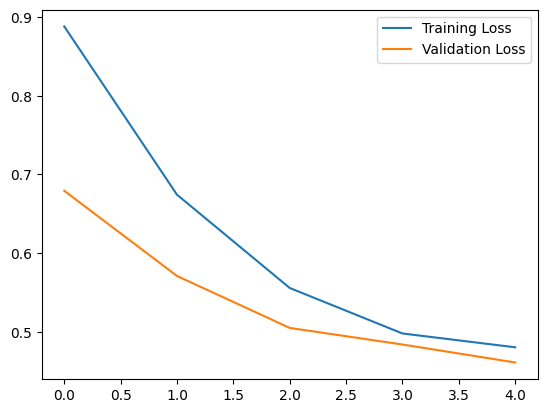

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

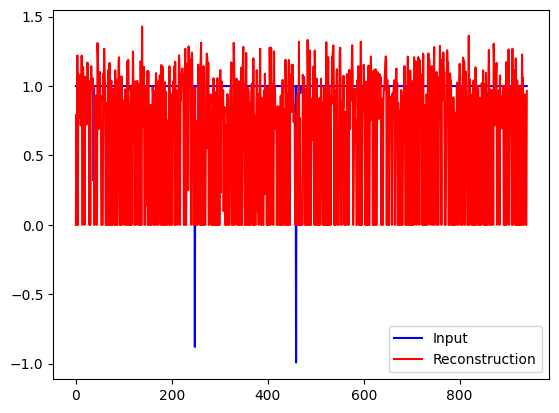

In [24]:

encoded_data = autoencoder.encoder(input_nparray).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(input_nparray[300], 'b')  # 元データのグラフ
plt.plot(decoded_data[300], 'r')   # 再構成データのグラフ
# plt.fill_between(np.arange(INPUT_SIZE), decoded_data[0], input_nparray[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

##### ▶コサイン類似度が1の場合を除いて分布を見てみる

In [9]:
all_cossim = []
for cossims in input_nparray:
    for cossim in cossims:
        if cossim < 0.9:
            all_cossim.append(cossim)

In [73]:
# plt.scatter(range(len(all_cossim)), all_cossim)
# plt.hist(all_cossim)

##### ▶座標数の確認（散布図）

In [72]:
# 全データ数 = 23535
# num = 23100
# len_coord = [len(coord) for coord in box_abct_nopt['ptx_mm']]
# len_coord_sort = sorted(len_coord)[num:]


# FIG_SIZE = (10, 30)
# fig, ax = plt.subplots(figsize=(FIG_SIZE[0],FIG_SIZE[1]))
# ax.grid(True)

# # ax.set_xticks(np.linspace(100, 0, 5))
# ax.set_yticks(np.linspace(380, 0, 77))
# ax.set_ylim([60,380])
# ax.scatter(range(len(len_coord_sort)), len_coord_sort, color='green', marker='.')
# print(len(len_coord))

##### ▶DTW(Dynamic Time Warping)

In [143]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

dtw_sim = []

timeline_1 = box_abct_nopt.iloc()[0]['cos_sim'] # drawing_id = 955, stroke_id = 3 saito
for i, row in enumerate(box_abct_nopt[:5000].iloc()):
    timeline_2 = row['cos_sim']
    distance, path = fastdtw(timeline_1, timeline_2, dist=2)
    # plt.plot(timeline_1, label='timeline_1')
    # plt.plot(timeline_2, label='timeline_2')
    # for x_, y_ in path:
    #   plt.plot([x_, y_], [timeline_1[x_], timeline_2[y_]], color='gray', linestyle='dotted', linewidth=1)
    # plt.legend()
    # plt.show()
    dtw_sim.append(distance)
    print(i, '/ 5000')

0 / 5000
1 / 5000
2 / 5000
3 / 5000
4 / 5000
5 / 5000
6 / 5000
7 / 5000
8 / 5000
9 / 5000
10 / 5000
11 / 5000
12 / 5000
13 / 5000
14 / 5000
15 / 5000
16 / 5000
17 / 5000
18 / 5000
19 / 5000
20 / 5000
21 / 5000
22 / 5000
23 / 5000
24 / 5000
25 / 5000
26 / 5000
27 / 5000
28 / 5000
29 / 5000
30 / 5000
31 / 5000
32 / 5000
33 / 5000
34 / 5000
35 / 5000
36 / 5000
37 / 5000
38 / 5000
39 / 5000
40 / 5000
41 / 5000
42 / 5000
43 / 5000
44 / 5000
45 / 5000
46 / 5000
47 / 5000
48 / 5000
49 / 5000
50 / 5000
51 / 5000
52 / 5000
53 / 5000
54 / 5000
55 / 5000
56 / 5000
57 / 5000
58 / 5000
59 / 5000
60 / 5000
61 / 5000
62 / 5000
63 / 5000
64 / 5000
65 / 5000
66 / 5000
67 / 5000
68 / 5000
69 / 5000
70 / 5000
71 / 5000
72 / 5000
73 / 5000
74 / 5000
75 / 5000
76 / 5000
77 / 5000
78 / 5000
79 / 5000
80 / 5000
81 / 5000
82 / 5000
83 / 5000
84 / 5000
85 / 5000
86 / 5000
87 / 5000
88 / 5000
89 / 5000
90 / 5000
91 / 5000
92 / 5000
93 / 5000
94 / 5000
95 / 5000
96 / 5000
97 / 5000
98 / 5000
99 / 5000
100 / 5000

In [148]:
# end = 5000
# box_head_5000 = box_abct_nopt[:end]
# df_dtw_sim = pd.DataFrame({'drawing_id': [row['drawing_id'] for row in box_head_5000.iloc()],
#             'stroke_id': [row['stroke_id'] for row in box_head_5000.iloc()],
#             'shape_int': [row['shape_int'] for row in box_head_5000.iloc()],
#             'dtw_sim_to_955_3': dtw_sim})

# df_dtw_sim.to_excel('../temp/20240206_dtwsim_test.xlsx')

# box_head_5000

<AxesSubplot: xlabel='dtw_sim_to_955_3', ylabel='shape_int'>

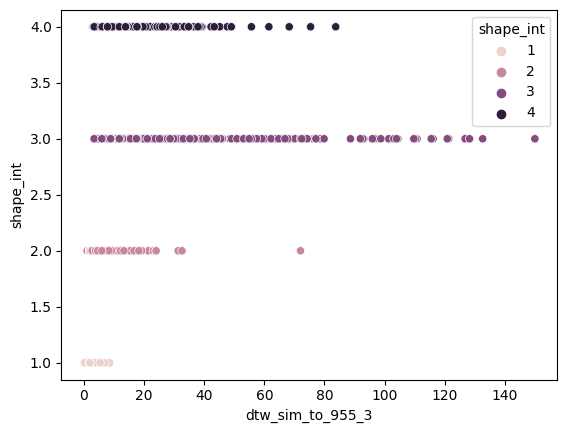

In [149]:
import seaborn as sns

df_dtw_sim = pd.read_excel('../temp/20240206_dtwsim_test.xlsx')
sns.scatterplot(data=df_dtw_sim, x='dtw_sim_to_955_3', y='shape_int', hue='shape_int')

Text(0.5, 0, 'x')

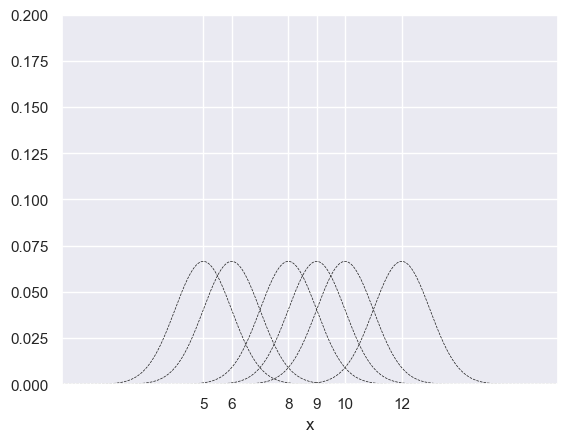

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
sns.set()

data = [ cos_sim for cos_sim in simple_shape['cos_sim']]
h = 1
n = len(data)

# 確率密度関数描画用のx軸データ
x = np.linspace(0, 20, 1000)

# 確率密度関数の値を取得
ys = []
for x_i in data:
    ys.append(norm.pdf(x, loc=x_i, scale=h) / n)

fig, ax = plt.subplots()
for i in range(len(ys)):
    ax.plot(x, ys[i], 'k--', linewidth=0.5)
ax.set_xlim(0, 17.5)
ax.set_ylim(0, 0.2)
ax.set_xticks(data)
ax.set_xlabel('x')